In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load and clean-up data
from numpy import nan
from pandas import read_csv
# univariate multi-step lstm
# import library 
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## Preparing Data

In [4]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Baron")
data

,Date,Hours,Hs [m],Angin [m/s]
0,2014-07-14 07:56:00,1,2.060,3.618206
1,2014-07-14 08:56:00,2,2.326,3.325107
2,2014-07-14 09:56:00,3,2.280,3.218061
3,2014-07-14 10:56:00,4,2.280,2.976261
4,2014-07-14 11:56:00,5,2.326,2.594406
...,...,...,...,...
1256,2014-09-04 15:56:00,1257,1.098,0.853453
1257,2014-09-04 16:56:00,1258,1.044,0.119597
1258,2014-09-04 17:56:00,1259,1.098,0.681651
1259,2014-09-04 18:56:00,1260,0.966,1.093551


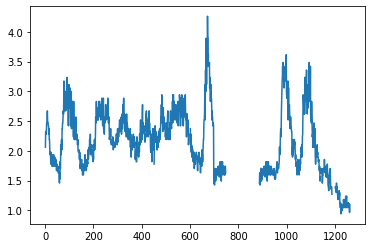

In [5]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [6]:
import copy
data_raw = copy.deepcopy(data)

### handling outliers

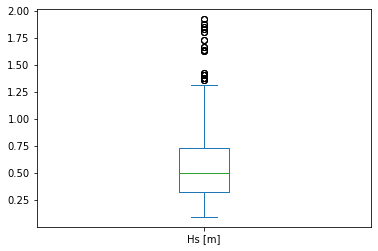

In [ ]:
data['Hs [m]'].plot(kind='box', sharex=False, sharey=False)
plt.show()

In [ ]:
# calculate q1, q3, iqr 
q1 = data['Hs [m]'].quantile(0.25)
q3 = data['Hs [m]'].quantile(0.75)
iqr = q3 - q1

In [ ]:
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ]

624     1.828
625     1.828
626     1.828
627     1.922
628     1.922
629     1.922
630     1.734
631     1.734
632     1.734
633     1.406
634     1.406
635     1.406
648     1.852
649     1.852
650     1.852
651     1.875
652     1.875
653     1.875
654     1.805
655     1.805
656     1.805
657     1.406
658     1.406
659     1.406
672     1.641
673     1.641
674     1.641
675     1.383
676     1.383
677     1.383
1449    1.383
1450    1.383
1451    1.383
1497    1.664
1498    1.664
1499    1.664
1500    1.359
1501    1.359
1502    1.359
2049    1.625
2050    1.625
2051    1.625
2277    1.422
2278    1.422
2279    1.422
Name: Hs [m], dtype: float64

In [ ]:
# outlier atas
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ] = np.nan

#outlier bawah
data['Hs [m]'].loc[(data['Hs [m]']< q1-(1.5*iqr)) & (data['Hs [m]']>= q1-(3*iqr)) ] = np.nan

# nilai ekstrim bawah
data['Hs [m]'].loc[data['Hs [m]']> q3 + (3*iqr) ] = np.nan

# nilai ekstrim atas
data['Hs [m]'].loc[data['Hs [m]']< q1 - (3*iqr) ] = np.nan

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
data.head()

,Date,Hours,Hs [m],Angin [m/s]
0,1999-01-12 00:00:00,1,0.281,3.450012
1,1999-01-12 01:00:00,2,0.281,3.195916
2,1999-01-12 02:00:00,3,0.281,3.480425
3,1999-01-12 03:00:00,4,0.234,3.734589
4,1999-01-12 04:00:00,5,0.234,3.478974


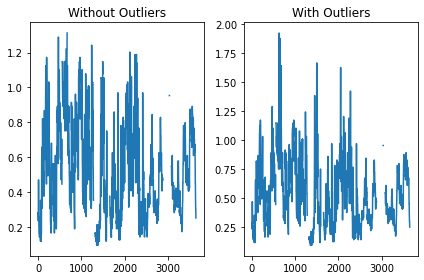

In [ ]:
plt.subplot(121)
plt.plot(data['Hs [m]'])
plt.title('Without Outliers')

plt.subplot(122)
plt.plot(data_raw['Hs [m]'])
plt.title('With Outliers')

plt.tight_layout()

### Interpolation

In [7]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [8]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [9]:
# drop NaN value in dataframe data
data = data.dropna()

In [10]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [11]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [12]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [13]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [14]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-14-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-14-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-14-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


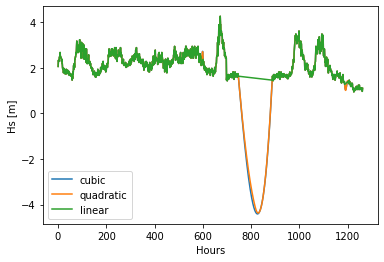

In [15]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

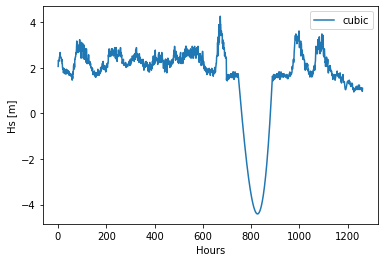

In [16]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

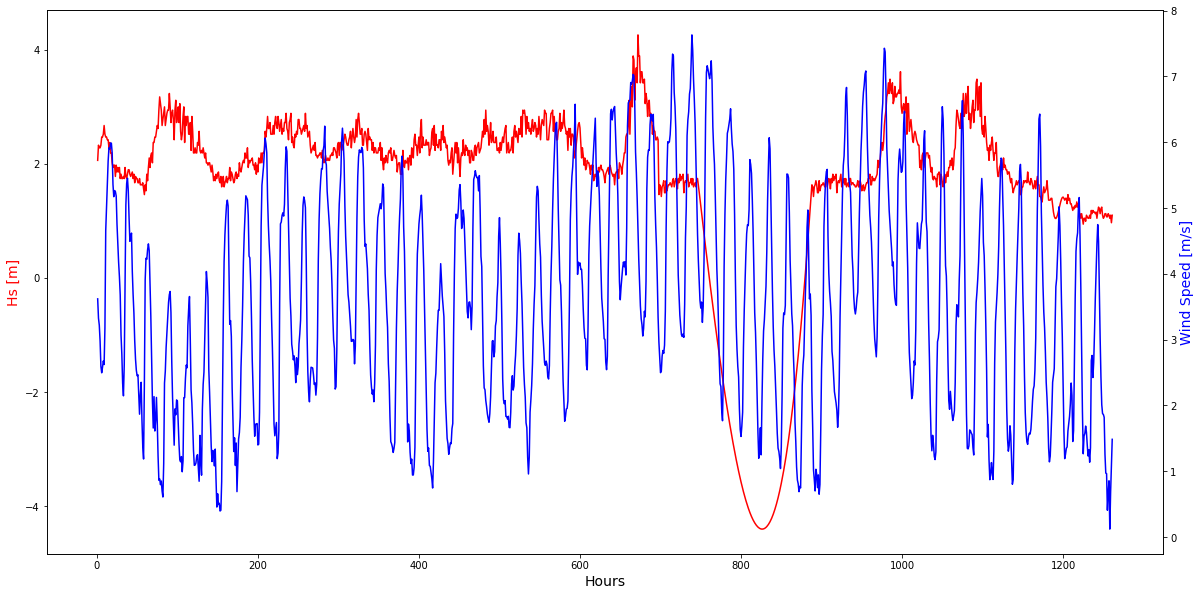

In [17]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

### splitting data

In [18]:
data_swh = data2[['Hs [m]','Angin [m/s]']]
type(data_swh), data_swh.shape

(pandas.core.frame.DataFrame, (1261, 2))

In [19]:
len(data_swh)

1261

In [ ]:
data_swh[1:5]

,Hs [m],Angin [m/s]
1,0.281,3.195916
2,0.281,3.480425
3,0.234,3.734589
4,0.234,3.478974


**Pembagian data**

train = data 70% --> 1 - 2556

val = data 10% --> 2557 - 2928

test = data 20% --> 2929 - 3648

In [20]:
train = data_swh[:888]
val = data_swh[888:1020]
test = data_swh[1020:1260]
train.shape, val.shape, test.shape

((888, 2), (132, 2), (240, 2))

In [21]:
# resturvture into windows of 12 hours data
train = array(split(train, round(len(train)/12)))
val = array(split(val, round(len(val)/12)))
test = array(split(test, round(len(test)/12)))
train.shape, val.shape, test.shape

((74, 12, 2), (11, 12, 2), (20, 12, 2))

In [22]:
n_input,n_out = 12,12
data_train = train.reshape((train.shape[0]*train.shape[1],train.shape[2] ))
data_val = val.reshape((val.shape[0]*val.shape[1],train.shape[2] ))
data_train.shape, data_val.shape

((888, 2), (132, 2))

In [23]:
len(data_train)

888

In [24]:
def split_into_xy(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [25]:
n_steps_in, n_steps_out = 12, 12
X_train, y_train = split_into_xy(data_train,n_steps_in, n_steps_out)
X_val, y_val = split_into_xy(data_val,n_steps_in, n_steps_out)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((865, 12, 2), (865, 12, 2), (109, 12, 2), (109, 12, 2))

In [26]:
n_features = 2
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape,X_val.shape

((865, 12, 2), (109, 12, 2))

In [27]:
y_train = y_train[:,:,0].reshape((y_train.shape[0], y_train.shape[1],))
y_val = y_val[:,:,0].reshape((y_val.shape[0], y_val.shape[1],))
y_train.shape,y_val.shape

((865, 12), (109, 12))

In [28]:
yyy

NameError: ignored

## Model

In [29]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               162400    
                                                                 
 repeat_vector (RepeatVector  (None, 12, 200)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 200)           320800    
                                                                 
 time_distributed (TimeDistr  (None, 12, 100)          20100     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 1)            101       
 tributed)                                                       
                                                        

In [30]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [31]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/100
27/28 [===========================>..] - ETA: 0s - loss: 4.8473 - root_mean_squared_error: 2.2017

28/28 [==============================] - 11s 290ms/step - loss: 4.8488 - root_mean_squared_error: 2.2020 - val_loss: 2.2130 - val_root_mean_squared_error: 1.4876
Epoch 2/100
27/28 [===========================>..] - ETA: 0s - loss: 2.1948 - root_mean_squared_error: 1.4815

28/28 [==============================] - 6s 223ms/step - loss: 2.1955 - root_mean_squared_error: 1.4817 - val_loss: 0.9105 - val_root_mean_squared_error: 0.9542
Epoch 3/100
27/28 [===========================>..] - ETA: 0s - loss: 1.0018 - root_mean_squared_error: 1.0009

28/28 [==============================] - 7s 250ms/step - loss: 1.0009 - root_mean_squared_error: 1.0005 - val_loss: 0.5612 - val_root_mean_squared_error: 0.7492
Epoch 4/100
27/28 [===========================>..] - ETA: 0s - loss: 0.6903 - root_mean_squared_error: 0.8309

28/28 [==============================] - 7s 239ms/step - loss: 0.6898 - root_mean_squared_error: 0.8305 - val_loss: 0.3549 - val_root_mean_squared_error: 0.5957
Epoch 5/100
27/28 [===========================>..] - ETA: 0s - loss: 0.4963 - root_mean_squared_error: 0.7045

28/28 [==============================] - 7s 240ms/step - loss: 0.4960 - root_mean_squared_error: 0.7042 - val_loss: 0.2473 - val_root_mean_squared_error: 0.4973
Epoch 6/100
27/28 [===========================>..] - ETA: 0s - loss: 0.3659 - root_mean_squared_error: 0.6049

28/28 [==============================] - 7s 257ms/step - loss: 0.3658 - root_mean_squared_error: 0.6048 - val_loss: 0.1827 - val_root_mean_squared_error: 0.4275
Epoch 7/100
28/28 [==============================] - 2s 74ms/step - loss: 0.3058 - root_mean_squared_error: 0.5530 - val_loss: 0.1889 - val_root_mean_squared_error: 0.4347
Epoch 8/100
27/28 [===========================>..] - ETA: 0s - loss: 0.2655 - root_mean_squared_error: 0.5152

28/28 [==============================] - 7s 275ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150 - val_loss: 0.1512 - val_root_mean_squared_error: 0.3889
Epoch 9/100
28/28 [==============================] - 3s 99ms/step - loss: 0.2475 - root_mean_squared_error: 0.4975 - val_loss: 0.1739 - val_root_mean_squared_error: 0.4170
Epoch 10/100
28/28 [==============================] - 2s 71ms/step - loss: 0.2373 - root_mean_squared_error: 0.4871 - val_loss: 0.1872 - val_root_mean_squared_error: 0.4327
Epoch 11/100
28/28 [==============================] - 2s 72ms/step - loss: 0.1920 - root_mean_squared_error: 0.4381 - val_loss: 0.3114 - val_root_mean_squared_error: 0.5580
Epoch 12/100
28/28 [==============================] - 2s 71ms/step - loss: 0.1849 - root_mean_squared_error: 0.4300 - val_loss: 0.2373 - val_root_mean_squared_error: 0.4872
Epoch 13/100
28/28 [==============================] - 5s 171ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288 - val_loss: 0.2129 - val_root_m

28/28 [==============================] - 7s 237ms/step - loss: 0.1642 - root_mean_squared_error: 0.4053 - val_loss: 0.1280 - val_root_mean_squared_error: 0.3577
Epoch 16/100
28/28 [==============================] - 2s 71ms/step - loss: 0.1955 - root_mean_squared_error: 0.4421 - val_loss: 0.1445 - val_root_mean_squared_error: 0.3801
Epoch 17/100
28/28 [==============================] - 2s 72ms/step - loss: 0.1662 - root_mean_squared_error: 0.4077 - val_loss: 0.1294 - val_root_mean_squared_error: 0.3598
Epoch 18/100
28/28 [==============================] - 3s 113ms/step - loss: 0.1511 - root_mean_squared_error: 0.3888 - val_loss: 0.1368 - val_root_mean_squared_error: 0.3699
Epoch 19/100
28/28 [==============================] - 2s 86ms/step - loss: 0.1366 - root_mean_squared_error: 0.3696 - val_loss: 0.1532 - val_root_mean_squared_error: 0.3915
Epoch 20/100
27/28 [===========================>..] - ETA: 0s - loss: 0.1451 - root_mean_squared_error: 0.3810

28/28 [==============================] - 6s 211ms/step - loss: 0.1457 - root_mean_squared_error: 0.3817 - val_loss: 0.0975 - val_root_mean_squared_error: 0.3122
Epoch 21/100
28/28 [==============================] - 2s 70ms/step - loss: 0.1663 - root_mean_squared_error: 0.4078 - val_loss: 0.1954 - val_root_mean_squared_error: 0.4421
Epoch 22/100
28/28 [==============================] - 3s 92ms/step - loss: 0.1506 - root_mean_squared_error: 0.3880 - val_loss: 0.2728 - val_root_mean_squared_error: 0.5223
Epoch 23/100
28/28 [==============================] - 3s 113ms/step - loss: 0.1365 - root_mean_squared_error: 0.3695 - val_loss: 0.1209 - val_root_mean_squared_error: 0.3477
Epoch 24/100
27/28 [===========================>..] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3572

28/28 [==============================] - 6s 233ms/step - loss: 0.1276 - root_mean_squared_error: 0.3572 - val_loss: 0.0928 - val_root_mean_squared_error: 0.3047
Epoch 25/100
28/28 [==============================] - 2s 72ms/step - loss: 0.1239 - root_mean_squared_error: 0.3520 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3555
Epoch 26/100
28/28 [==============================] - 2s 81ms/step - loss: 0.1267 - root_mean_squared_error: 0.3560 - val_loss: 0.1520 - val_root_mean_squared_error: 0.3899
Epoch 27/100
28/28 [==============================] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3525

28/28 [==============================] - 7s 264ms/step - loss: 0.1243 - root_mean_squared_error: 0.3525 - val_loss: 0.0869 - val_root_mean_squared_error: 0.2949
Epoch 28/100
28/28 [==============================] - 2s 70ms/step - loss: 0.1190 - root_mean_squared_error: 0.3450 - val_loss: 0.1290 - val_root_mean_squared_error: 0.3591
Epoch 29/100
28/28 [==============================] - 2s 71ms/step - loss: 0.1251 - root_mean_squared_error: 0.3537 - val_loss: 0.0958 - val_root_mean_squared_error: 0.3095
Epoch 30/100
27/28 [===========================>..] - ETA: 0s - loss: 0.1411 - root_mean_squared_error: 0.3756

28/28 [==============================] - 8s 287ms/step - loss: 0.1410 - root_mean_squared_error: 0.3755 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2878
Epoch 31/100
27/28 [===========================>..] - ETA: 0s - loss: 0.1184 - root_mean_squared_error: 0.3441

28/28 [==============================] - 7s 247ms/step - loss: 0.1183 - root_mean_squared_error: 0.3440 - val_loss: 0.0792 - val_root_mean_squared_error: 0.2815
Epoch 32/100
28/28 [==============================] - 2s 70ms/step - loss: 0.1072 - root_mean_squared_error: 0.3275 - val_loss: 0.1340 - val_root_mean_squared_error: 0.3661
Epoch 33/100
28/28 [==============================] - 3s 110ms/step - loss: 0.1476 - root_mean_squared_error: 0.3842 - val_loss: 0.0890 - val_root_mean_squared_error: 0.2984
Epoch 34/100
28/28 [==============================] - 2s 86ms/step - loss: 0.1133 - root_mean_squared_error: 0.3366 - val_loss: 0.1096 - val_root_mean_squared_error: 0.3311
Epoch 35/100
28/28 [==============================] - 2s 71ms/step - loss: 0.1367 - root_mean_squared_error: 0.3697 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2857
Epoch 36/100
28/28 [==============================] - 2s 72ms/step - loss: 0.1033 - root_mean_squared_error: 0.3214 - val_loss: 0.0832 - val_root_

28/28 [==============================] - 7s 262ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2801
Epoch 52/100
28/28 [==============================] - 2s 69ms/step - loss: 0.0633 - root_mean_squared_error: 0.2515 - val_loss: 0.0845 - val_root_mean_squared_error: 0.2907
Epoch 53/100
28/28 [==============================] - 2s 71ms/step - loss: 0.0614 - root_mean_squared_error: 0.2479 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2868
Epoch 54/100
28/28 [==============================] - 2s 72ms/step - loss: 0.0636 - root_mean_squared_error: 0.2522 - val_loss: 0.1544 - val_root_mean_squared_error: 0.3929
Epoch 55/100
28/28 [==============================] - 3s 93ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.1016 - val_root_mean_squared_error: 0.3188
Epoch 56/100
28/28 [==============================] - 3s 118ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.1067 - val_root_

28/28 [==============================] - 6s 224ms/step - loss: 0.0533 - root_mean_squared_error: 0.2308 - val_loss: 0.0712 - val_root_mean_squared_error: 0.2668
Epoch 75/100
28/28 [==============================] - 3s 110ms/step - loss: 0.0519 - root_mean_squared_error: 0.2279 - val_loss: 0.0819 - val_root_mean_squared_error: 0.2862
Epoch 76/100
28/28 [==============================] - 2s 68ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.0812 - val_root_mean_squared_error: 0.2850
Epoch 77/100
27/28 [===========================>..] - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.2229

28/28 [==============================] - 6s 224ms/step - loss: 0.0496 - root_mean_squared_error: 0.2228 - val_loss: 0.0702 - val_root_mean_squared_error: 0.2649
Epoch 78/100
28/28 [==============================] - 2s 71ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.0864 - val_root_mean_squared_error: 0.2939
Epoch 79/100
28/28 [==============================] - 3s 119ms/step - loss: 0.0500 - root_mean_squared_error: 0.2237 - val_loss: 0.1623 - val_root_mean_squared_error: 0.4029
Epoch 80/100
28/28 [==============================] - 4s 139ms/step - loss: 0.0661 - root_mean_squared_error: 0.2570 - val_loss: 0.1369 - val_root_mean_squared_error: 0.3701
Epoch 81/100
28/28 [==============================] - 4s 133ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0771 - val_root_mean_squared_error: 0.2776
Epoch 82/100
28/28 [==============================] - 3s 89ms/step - loss: 0.0537 - root_mean_squared_error: 0.2317 - val_loss: 0.1030 - val_roo

In [32]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [33]:
history = [x for x in val]
predictions = list()
for i in range(len(test)):
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  input_x = data[-n_input:,: ]
  input_x = input_x.reshape((1, len(input_x), 2))
  # predict the week
  yhat = model.predict(input_x, verbose=0)
  yhat_sequence = yhat[0]
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])

In [34]:
array(predictions).shape

(20, 12, 1)

In [35]:
prediksi = array(predictions)
observasi = test[:,:,0]
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [36]:
import pandas as pd
test_results = pd.DataFrame(data={'Univariate':prediksi.flatten(), 
                                   'Actuals':observasi.flatten()})
test_results

,Univariate,Actuals
0,2.509493,2.326
1,2.446121,1.935
2,2.427046,2.060
3,2.437499,1.895
4,2.410832,2.146
...,...,...
235,1.249389,1.125
236,1.266068,1.098
237,1.286102,1.044
238,1.309132,1.098


In [38]:
test_results['Date'] = data2['Date'].iloc[1020:1260].values
test_results.head()

,Univariate,Actuals,Date
0,2.509493,2.326,2014-08-25 19:56:00
1,2.446121,1.935,2014-08-25 20:56:00
2,2.427046,2.060,2014-08-25 21:56:00
3,2.437499,1.895,2014-08-25 22:56:00
4,2.410832,2.146,2014-08-25 23:56:00


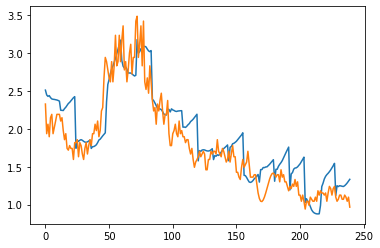

In [39]:
plt.plot(test_results['Univariate'])
plt.plot(test_results['Actuals'])

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Univariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',fillcolor='#ff0000',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [41]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Univariate'])
RMSE = math.sqrt(MSE)
RMSE

0.2936224884079976

In [42]:
from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Univariate'])
corr

0.89877552957596

In [43]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Univariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

0.1236060216287727

In [44]:
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multi-step/multivariate_12jam_lstm_baron.csv')